# Lab 6: More practice writing iterative algorithms

- [Coordinate descent for LASSO](#Coordinate-descent-for-LASSO)
- [Powells Method](#Powells-Method)
- [K-Means Clustering](#K-Means-Clustering)

In [24]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

## Coordinate descent for LASSO

Coordinate descent is an optimization algorithm that successively minimizes a function with respect to one of its variables while fixing the values of the other variables. It is a popular algorithm for fitting the LASSO (Least Absolute Shrinkage and Selection Operator) model, which is a linear regression model with an added regularization term that penalizes the absolute values of the coefficients.

In the `CoordinateDescentLasso` class, we implement the coordinate descent algorithm for LASSO. The `fit` method minimizes the LASSO objective function using coordinate descent, and the `predict` method makes predictions using the trained model. The `soft_threshold` method applies the soft-thresholding operator, which is used to update the coefficients in the algorithm.

$$
\begin{aligned}
\text{Objective function:} \quad & \frac{1}{2n} \lVert y - Xw \rVert_2^2 + \alpha \lVert w \rVert_1 \\
\text{Soft-thresholding operator:} \quad & S(\rho, \alpha) = \begin{cases} \rho - \alpha & \text{if } \rho > \alpha \\ \rho + \alpha & \text{if } \rho < -\alpha \\ 0 & \text{otherwise} \end{cases} \\
\beta_j = & S\left(\frac{1}{n} X_j^T \left(y - Xw + w_j X_j\right), \alpha\right) \quad \text{for } j = 0, 1, \ldots, p-1
\end{aligned}
$$

In [2]:
class CoordinateDescentLasso:
    def __init__(self, alpha=1.0, tol=1e-4, max_iter=1000):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.coef_ = None

    def soft_threshold(self, rho, alpha):
        if rho < -alpha:
            return rho + alpha
        elif rho > alpha:
            return rho - alpha
        else:
            return 0.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)  # Initialize coefficients

        for iteration in range(self.max_iter):
            coef_old = self.coef_.copy()

            for j in range(n_features):
                X_j = X[:, j]
                residual = y - (X @ self.coef_) + (self.coef_[j] * X_j)
                rho = np.dot(X_j, residual) / n_samples

                # Update coefficient with soft-thresholding
                self.coef_[j] = self.soft_threshold(rho, self.alpha)

            # Convergence check
            if np.max(np.abs(self.coef_ - coef_old)) < self.tol:
                break

    def predict(self, X):
        """Makes predictions using the trained model."""
        return X @ self.coef_

In [8]:
# Generate synthetic data
X, y = make_regression(n_samples=100, n_features=10, noise=10, random_state=42)

# Train coordinate descent LASSO
lasso = CoordinateDescentLasso(alpha=0.1)
lasso.fit(X, y)

# Print coefficients
print("LASSO Coefficients:", lasso.coef_)

LASSO Coefficients: [16.56451709 45.2497754   3.03579479 63.9942669  88.2978461  74.38934245
 87.84055259  7.29266073  4.96390203 58.57946155]
MSE: 347.4969994534221


## Powells Method

Powell’s method is an optimization algorithm that is used to find the minimum of a function without calculating derivatives. It is an iterative algorithm that successively minimizes the function along a set of directions in the parameter space. In the `PowellsMethod` class, we implement Powell’s method for unconstrained optimization. The `optimize` method minimizes a function using Powell’s method, and the `line_search` method performs a simple backtracking line search to find the optimal step size in a given direction.

In [17]:
class PowellsMethod:
    def __init__(self, tol=1e-4, max_iter=1000):
        self.tol = tol
        self.max_iter = max_iter

    def optimize(self, func, x0):
        n = len(x0)
        directions = np.eye(n)
        x = np.array(x0, dtype=float)
    
        for iteration in range(self.max_iter):
            x_old = x.copy()
    
            for i in range(n):
                def f1d(alpha):
                    return func(x + alpha * directions[i])
    
                # Line search in the direction i
                alpha_opt = self.line_search(f1d)
                x += alpha_opt * directions[i]
    
            # Update direction vectors using the last displacement
            new_direction = x - x_old
            directions = np.roll(directions, shift=-1, axis=0)
            directions[-1] = new_direction / np.linalg.norm(new_direction) if np.linalg.norm(new_direction) > 1e-10 else directions[-1]
    
            # Convergence check
            if np.linalg.norm(x - x_old) < self.tol:
                break
    
        return x, func(x)
    
    def line_search(self, f1d, alpha_init=1.0, tau=0.5, c=1e-4):
        alpha = alpha_init
        while f1d(alpha) > f1d(0) - c * alpha * f1d(0):
            alpha *= tau
        return alpha


In [18]:
def rosenbrock(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2
    
# Initial point
x0 = np.array([0.0, 0.0])

# Run Powell's Method
optimizer = PowellsMethod()
optimal_x, optimal_val = optimizer.optimize(rosenbrock, x0)

print("Optimal solution:", optimal_x)
print("Optimal function value:", optimal_val)

Optimal solution: [0.31063391 0.07765848]
Optimal function value: 0.5107011346218376


## K-Means Clustering

K-Means clustering is an unsupervised machine learning algorithm that partitions the data into k clusters. The algorithm works by iteratively assigning each data point to the nearest cluster center and then updating the cluster centers based on the assigned data points. In the `KMeansClustering` class, the `fit` method fits the K-Means model to the data, and the `predict` method assigns each sample to the nearest cluster center.

In [19]:
class KMeansClustering:
    def __init__(self, k=3, max_iter=100, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels_ = None
    
    def fit(self, X):
        n_samples, _ = X.shape
        
        # Initialize centroids randomly
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]
        
        for _ in range(self.max_iter):
            # Assign each sample to the closest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            
            # Compute new centroids
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
            
            # Convergence check
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels
        
    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

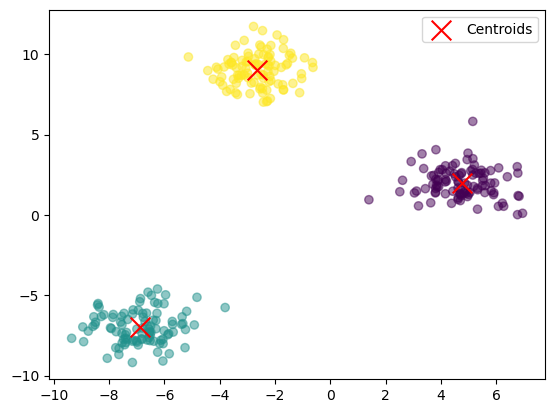

In [21]:
# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=3, random_state=42)
    
# Apply K-Means
kmeans = KMeansClustering(k=3)
kmeans.fit(X)
    
# Plot results
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()